In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from IPython.core.display import display, HTML
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from scipy.stats import uniform
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve,f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

In [8]:
train_data =  "./spoty_train_multiclass.csv"
train = pd.read_csv(train_data)
test_data = "./spoty_test_multiclass.csv"
test = pd.read_csv(test_data)

In [23]:
def train_data():
    y_train = train['genre']
    X_train = train.drop('genre',axis='columns')
    y_test = test['genre']
    X_test = test.drop('genre',axis='columns')
    return X_train, X_test, y_train, y_test

In [3]:
gridSearch = False

## Logistic regression

In [58]:
X_train, X_test, y_train, y_test = train_data() # loading data
mms = StandardScaler().fit(X_train)
X_train = mms.transform(X_train)
X_test = mms.transform(X_test)

if gridSearch:
    c_dist = uniform(0.01, 2) # continuous value
    elastic_l1_ratio = uniform(0, 1)
    # not all combinations are valid, thats why I use a list of dicts
    parameters = [{"C": c_dist, "solver":["newton-cg"], "penalty": ["l2"], "dual": [False]},
        {"C": c_dist, "solver":["lbfgs"], "penalty": ["l2"], "dual": [False]},
        {"C": c_dist, "solver":["liblinear"], "penalty": ["l1"], "dual": [False]},
        {"C": c_dist, "solver":["liblinear"], "penalty": ["l2"], "dual": [False]},
        {"C": c_dist, "solver":["sag"], "penalty": ["l2"], "dual": [False]},
        {"C": c_dist, "solver":["saga"], "penalty": ["l1", "l2"], "dual": [False]},
        {"solver":["saga"], "penalty": ["none"], "dual": [False]},
        {"C": c_dist, "solver":["saga"], "penalty": ["elasticnet"], "dual": [False], "l1_ratio": elastic_l1_ratio}]
else :
    parameters = {'C': [0.6065646519120615], 'dual': [False], 'l1_ratio': [0.5699649107012649], 'penalty': ['elasticnet'], 'solver': ['saga']}

model = LogisticRegression(class_weight='balanced',multi_class='multinomial')
grid = RandomizedSearchCV(model, parameters, n_iter=6000, cv=5, random_state=0, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
test_acc = best_model.score(X=X_test, y=y_test)
train_acc = best_model.score(X=X_train, y=y_train)

print('\nLogisitc Regression:')
print('- Best Params:', grid.best_params_)
print(f'- Accuracy: {{ train: {train_acc:.3f}, CV: {grid.best_score_:.3f}, test: {test_acc:.3f}}}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/miriam/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/miriam/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/miriam/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/miriam/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/miriam/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Logisitc Regression:
- Best Params: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.5699649107012649, 'dual': False, 'C': 0.6065646519120615}
- Accuracy: { train: 0.559, CV: 0.556, test: 0.563}


In [59]:
pd.DataFrame(grid.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head()

,params,mean_test_score,rank_test_score
0,"{'solver': 'saga', 'penalty': 'elasticnet', 'l...",0.555907,1


In [60]:
print(classification_report(y_test,grid.predict(X_test), digits=3))

cm = confusion_matrix(y_test, grid.predict(X_test))
print ('\nConfusion matrix: \n', cm)



                 precision    recall  f1-score   support

      Dark Trap      0.571     0.337     0.424      1168
            Emo      0.381     0.528     0.442       472
         Hiphop      0.452     0.388     0.418       793
            Pop      0.131     0.438     0.202       146
            Rap      0.354     0.469     0.404       537
            RnB      0.402     0.314     0.353       576
     Trap Metal      0.382     0.561     0.454       542
Underground Rap      0.501     0.322     0.392      1188
            dnb      0.765     0.798     0.781       722
      hardstyle      0.576     0.588     0.582       701
      psytrance      0.786     0.861     0.822       796
      techhouse      0.717     0.775     0.745       681
         techno      0.793     0.808     0.801       825
         trance      0.656     0.647     0.652       862
           trap      0.665     0.672     0.669       705

       accuracy                          0.563     10714
      macro avg      0.542   

# Linear SVM

In [62]:
X_train, X_test, y_train, y_test = train_data() # loading data
mms = StandardScaler().fit(X_train)
X_train = mms.transform(X_train)
X_test = mms.transform(X_test)

if gridSearch:
    c_dist = uniform(0.01, 2) 
    # not all combinations are valid, thats why I use a list of dicts (l1 with hinge)
    parameters = [{'C': c_dist,  'penalty': ['l1'], 'loss': ['squared_hinge'], 'dual': [False]},
        {'C': c_dist,  'penalty': ['l2'], 'loss': ['hinge','squared_hinge'], 'dual': [False]}]
else:
    parameters = {'C': [1.7045034775682508], 'dual': [False], 'loss': ['squared_hinge'], 'penalty': ['l2']} 

model = svm. = 0.00005, class_weight='balanced')
grid = RandomizedSearchCV(model, parameters, cv=5, random_state=0, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
test_acc = best_model.score(X=X_test, y=y_test)
train_acc = best_model.score(X=X_train, y=y_train)

print('\nLinear SVM:')
print('- Best Params:', grid.best_params_)
print(f'- Accuracy: {{ train: {train_acc:.3f}, CV: {grid.best_score_:.3f}, test: {test_acc:.3f}}}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Linear SVM:
- Best Params: {'penalty': 'l2', 'loss': 'squared_hinge', 'dual': False, 'C': 1.7045034775682508}
- Accuracy: { train: 0.540, CV: 0.538, test: 0.544}


In [63]:
pd.DataFrame(grid.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head()

,params,mean_test_score,rank_test_score
0,"{'penalty': 'l2', 'loss': 'squared_hinge', 'du...",0.537825,1


In [64]:

print(classification_report(y_test,grid.predict(X_test), digits=3))

cm = confusion_matrix(y_test, grid.predict(X_test))
print ('\nConfusion matrix: \n', cm)

                 precision    recall  f1-score   support

      Dark Trap      0.568     0.320     0.409      1168
            Emo      0.332     0.536     0.410       472
         Hiphop      0.452     0.393     0.421       793
            Pop      0.092     0.110     0.100       146
            Rap      0.322     0.462     0.380       537
            RnB      0.372     0.316     0.342       576
     Trap Metal      0.379     0.432     0.404       542
Underground Rap      0.515     0.323     0.397      1188
            dnb      0.669     0.831     0.741       722
      hardstyle      0.602     0.496     0.544       701
      psytrance      0.740     0.834     0.784       796
      techhouse      0.623     0.771     0.689       681
         techno      0.735     0.807     0.769       825
         trance      0.623     0.636     0.630       862
           trap      0.594     0.679     0.634       705

       accuracy                          0.544     10714
      macro avg      0.508   

# SVM with RBF kernel

In [65]:
X_train, X_test, y_train, y_test = train_data() # loading data
mms = StandardScaler().fit(X_train)
X_train = mms.transform(X_train)
X_test = mms.transform(X_test)

if gridSearch:
    c_dist = uniform(0.01, 2)
    param = {"C": c_dist, "gamma": ["scale", "auto"]}
else :
    param = {'C': [1.969173457625457], 'gamma': ['auto']}

model = svm.SVC(kernel="rbf",class_weight='balanced')
grid = RandomizedSearchCV(model, param, n_iter=1000, cv=5, random_state=0, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
test_acc = best_model.score(X=X_test, y=y_test)
train_acc = best_model.score(X=X_train, y=y_train)

print('\nSVM with RBF kernel:')
print('- Best Params:', grid.best_params_)
print(f'- Accuracy: {{ train: {train_acc:.3f}, CV: {grid.best_score_:.3f}, test: {test_acc:.3f}}}')



Fitting 5 folds for each of 1 candidates, totalling 5 fits

SVM with RBF kernel:
- Best Params: {'gamma': 'auto', 'C': 1.969173457625457}
- Accuracy: { train: 0.691, CV: 0.633, test: 0.646}


In [66]:
pd.DataFrame(grid.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head()

,params,mean_test_score,rank_test_score
0,"{'gamma': 'auto', 'C': 1.969173457625457}",0.633476,1


In [67]:
print(classification_report(y_test,grid.predict(X_test), digits=3))

cm = confusion_matrix(y_test, grid.predict(X_test))
print ('\nConfusion matrix: \n', cm)

                 precision    recall  f1-score   support

      Dark Trap      0.616     0.431     0.507      1168
            Emo      0.573     0.633     0.602       472
         Hiphop      0.464     0.426     0.444       793
            Pop      0.169     0.438     0.244       146
            Rap      0.384     0.566     0.457       537
            RnB      0.408     0.384     0.395       576
     Trap Metal      0.424     0.565     0.484       542
Underground Rap      0.510     0.360     0.422      1188
            dnb      0.911     0.932     0.921       722
      hardstyle      0.777     0.833     0.804       701
      psytrance      0.874     0.915     0.894       796
      techhouse      0.807     0.828     0.817       681
         techno      0.849     0.847     0.848       825
         trance      0.784     0.799     0.791       862
           trap      0.796     0.732     0.763       705

       accuracy                          0.646     10714
      macro avg      0.623   

# Random Forest (final model)

In [33]:
X_train, X_test, y_train, y_test = train_data() # loading data

if gridSearch:
    n_est = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 10)]
    max_d = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_d.append(None)
    parameters = {'n_estimators': n_est, 'max_features': ['log2','sqrt',None], 'bootstrap': [True,False], 'max_depth': max_d, 'min_samples_split': [5, 6, 8, 10], 'min_samples_leaf': [1, 2, 4]}
else :
    parameters = {'n_estimators': [645], 'min_samples_split': [5], 'min_samples_leaf': [2], 'max_features': ['sqrt'], 'max_depth': [200], 'bootstrap': [True]}
    
model = RandomForestClassifier(class_weight='balanced')
grid = RandomizedSearchCV(model, parameters, n_iter=1000, cv=5, random_state=0, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
test_acc = best_model.score(X=X_test, y=y_test)
train_acc = best_model.score(X=X_train, y=y_train)

print('\nRandom Forest:')
print('- Best Params:', grid.best_params_)
print(f'- Accuracy: {{ train: {train_acc:.3f}, CV: {grid.best_score_:.3f}, test: {test_acc:.3f}}}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Random Forest:
- Best Params: {'n_estimators': 645, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 200, 'bootstrap': True}
- Accuracy: { train: 0.979, CV: 0.681, test: 0.695}


In [34]:
pd.DataFrame(grid.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head()

,params,mean_test_score,rank_test_score
0,"{'n_estimators': 645, 'min_samples_split': 5, ...",0.681442,1


In [35]:
print(classification_report(y_test,grid.predict(X_test), digits=3))

cm = confusion_matrix(y_test, grid.predict(X_test))
print ('\nConfusion matrix: \n', cm)

                 precision    recall  f1-score   support

      Dark Trap      0.607     0.543     0.573      1168
            Emo      0.677     0.742     0.708       472
         Hiphop      0.485     0.477     0.481       793
            Pop      0.286     0.123     0.172       146
            Rap      0.586     0.458     0.514       537
            RnB      0.431     0.474     0.452       576
     Trap Metal      0.484     0.480     0.482       542
Underground Rap      0.473     0.522     0.496      1188
            dnb      0.956     0.990     0.973       722
      hardstyle      0.834     0.882     0.857       701
      psytrance      0.893     0.936     0.914       796
      techhouse      0.868     0.881     0.875       681
         techno      0.853     0.864     0.859       825
         trance      0.825     0.839     0.832       862
           trap      0.805     0.780     0.793       705

       accuracy                          0.695     10714
      macro avg      0.671   

## Visualizing Final model

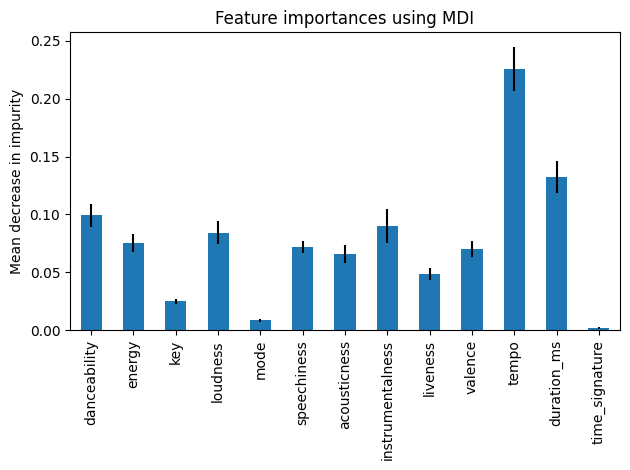

In [47]:
best_model = grid.best_estimator_
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.tick_params(axis='x', labelsize=10)
fig.tight_layout()

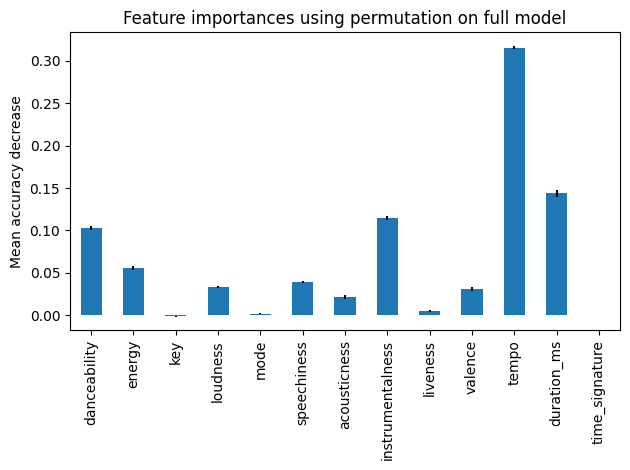

In [45]:
result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
ax.tick_params(axis='x', labelsize=10)
fig.tight_layout()
plt.show()
